# Basic Compositional Learning with Referential Games

This notebook implements a simple compositional learning system using referential games. We'll create a speaker and listener agent that learn to communicate about images with compositional attributes (color and shape).

## References:
1. Lazaridou, A., Peysakhovich, A., & Baroni, M. (2017). Multi-agent cooperation and the emergence of (natural) language. arXiv preprint arXiv:1612.07182.
2. Mordatch, I., & Abbeel, P. (2018). Emergence of grounded compositional language in multi-agent populations. In Thirty-second AAAI conference on artificial intelligence.
3. Lake, B. M., & Baroni, M. (2018). Generalization without systematicity: On the compositional skills of sequence-to-sequence recurrent networks. arXiv preprint arXiv:1711.00350.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Image Generator

We'll create a simple image generator that produces "images" with two compositional attributes: color and shape. Each attribute will be represented as a one-hot encoded vector.

In [2]:
class ImageGenerator:
    def __init__(self, num_colors=4, num_shapes=4):
        self.num_colors = num_colors
        self.num_shapes = num_shapes
    
    def generate(self, batch_size):
        colors = torch.eye(self.num_colors)[torch.randint(0, self.num_colors, (batch_size,))]
        shapes = torch.eye(self.num_shapes)[torch.randint(0, self.num_shapes, (batch_size,))]
        images = torch.cat((colors, shapes), dim=1).to(device)
        return images

generator = ImageGenerator()
sample_images = generator.generate(5)
print("Sample images:")
print(sample_images)

Sample images:
tensor([[0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')


## Speaker Agent

The speaker agent takes an image as input and produces a discrete message. We'll use the Gumbel-Softmax trick for differentiable discrete communication [3].

In [3]:
class SpeakerAgent(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(SpeakerAgent, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, tau=1.0, hard=False):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)
        return torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=hard)

speaker = SpeakerAgent(8, 64, 10).to(device)
sample_messages = speaker(sample_images)
print("Sample messages:")
print(sample_messages)

Sample messages:
tensor([[0.0013, 0.0087, 0.0029, 0.0092, 0.0057, 0.0024, 0.9468, 0.0033, 0.0133,
         0.0065],
        [0.0174, 0.0256, 0.0837, 0.0150, 0.0331, 0.0114, 0.0616, 0.0047, 0.6194,
         0.1281],
        [0.0277, 0.0982, 0.0458, 0.1696, 0.0651, 0.1720, 0.0742, 0.1060, 0.2081,
         0.0333],
        [0.0030, 0.8442, 0.0046, 0.0487, 0.0028, 0.0385, 0.0290, 0.0153, 0.0095,
         0.0044],
        [0.2942, 0.3944, 0.0983, 0.0264, 0.0078, 0.0154, 0.0445, 0.0100, 0.0560,
         0.0530]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Listener Agent

The listener agent receives a message and tries to identify the correct image from a set of candidates.

In [4]:
class ListenerAgent(nn.Module):
    def __init__(self, message_size, image_size, hidden_size):
        super(ListenerAgent, self).__init__()
        self.fc1 = nn.Linear(message_size + image_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, message, images):
        batch_size, num_candidates, _ = images.shape
        message = message.unsqueeze(1).repeat(1, num_candidates, 1)
        x = torch.cat((message, images), dim=2)
        x = x.view(batch_size * num_candidates, -1)
        x = torch.relu(self.fc1(x))
        scores = self.fc2(x).view(batch_size, num_candidates)
        return scores

listener = ListenerAgent(10, 8, 64).to(device)
candidate_images = generator.generate(5 * 3).view(5, 3, -1)
sample_scores = listener(sample_messages, candidate_images)
print("Sample scores:")
print(sample_scores)

Sample scores:
tensor([[ 0.0006,  0.2516,  0.1783],
        [ 0.1420,  0.1844,  0.0343],
        [ 0.1363,  0.1652,  0.0249],
        [-0.0039, -0.0039,  0.2568],
        [-0.0026,  0.1023,  0.2289]], device='cuda:0', grad_fn=<ViewBackward0>)


## Training Loop

Now we'll implement the training loop for our compositional learning system. We'll use the approach described in [1] and [2], where the agents play referential games to learn compositional concepts.

Epoch 100/1000, Loss: 1.1000, Accuracy: 0.3438
Epoch 200/1000, Loss: 0.8968, Accuracy: 0.7969
Epoch 300/1000, Loss: 0.4583, Accuracy: 0.8750
Epoch 400/1000, Loss: 0.3245, Accuracy: 0.8750
Epoch 500/1000, Loss: 0.3040, Accuracy: 0.8594
Epoch 600/1000, Loss: 0.2649, Accuracy: 0.8906
Epoch 700/1000, Loss: 0.3106, Accuracy: 0.9062
Epoch 800/1000, Loss: 0.3274, Accuracy: 0.9062
Epoch 900/1000, Loss: 0.2948, Accuracy: 0.9062
Epoch 1000/1000, Loss: 0.1938, Accuracy: 0.9375


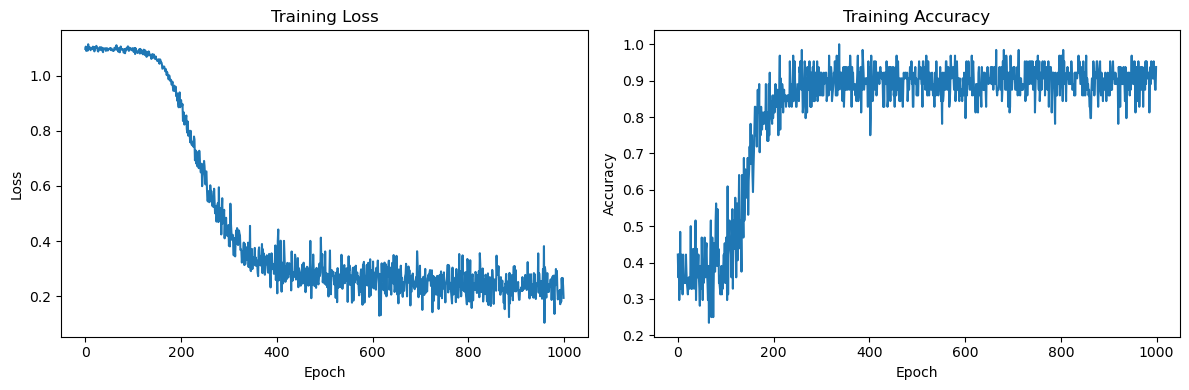

In [5]:
def train(speaker, listener, generator, num_epochs, batch_size, lr=0.001):
    speaker_optimizer = optim.Adam(speaker.parameters(), lr=lr)
    listener_optimizer = optim.Adam(listener.parameters(), lr=lr)
    
    losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        speaker_optimizer.zero_grad()
        listener_optimizer.zero_grad()
        
        # Generate target and distractor images
        target_images = generator.generate(batch_size)
        distractor_images = generator.generate(batch_size * 2)
        all_images = torch.cat([target_images.unsqueeze(1), 
                                distractor_images.view(batch_size, 2, -1)], dim=1)
        
        # Speaker generates messages
        messages = speaker(target_images)
        
        # Listener tries to identify target images
        scores = listener(messages, all_images)
        
        # Compute loss and accuracy
        loss = nn.functional.cross_entropy(scores, torch.zeros(batch_size, dtype=torch.long, device=device))
        accuracy = (scores.argmax(dim=1) == 0).float().mean()
        
        # Backpropagation
        loss.backward()
        speaker_optimizer.step()
        listener_optimizer.step()
        
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}")
    
    return losses, accuracies

# Training
num_epochs = 1000
batch_size = 64
losses, accuracies = train(speaker, listener, generator, num_epochs, batch_size)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

## Evaluation

Let's evaluate our trained agents on some test examples to see if they've learned compositional concepts.

In [6]:
def evaluate(speaker, listener, generator, num_samples=100):
    speaker.eval()
    listener.eval()
    
    with torch.no_grad():
        target_images = generator.generate(num_samples)
        distractor_images = generator.generate(num_samples * 2)
        all_images = torch.cat([target_images.unsqueeze(1), 
                                distractor_images.view(num_samples, 2, -1)], dim=1)
        
        messages = speaker(target_images, tau=0.5, hard=True)
        scores = listener(messages, all_images)
        
        accuracy = (scores.argmax(dim=1) == 0).float().mean()
    
    print(f"Test Accuracy: {accuracy.item():.4f}")
    
    # Analyze a few examples
    for i in range(5):
        target = target_images[i]
        message = messages[i]
        
        color = "RGYB"[target[:4].argmax().item()]
        shape = "CSTT"[target[4:].argmax().item()]
        
        print(f"Example {i+1}:")
        print(f"  Target: Color={color}, Shape={shape}")
        print(f"  Message: {message.argmax().item()}")
        print(f"  Correct: {'Yes' if scores[i].argmax().item() == 0 else 'No'}")

evaluate(speaker, listener, generator)

Test Accuracy: 0.8900
Example 1:
  Target: Color=R, Shape=T
  Message: 4
  Correct: Yes
Example 2:
  Target: Color=Y, Shape=T
  Message: 0
  Correct: Yes
Example 3:
  Target: Color=R, Shape=S
  Message: 4
  Correct: Yes
Example 4:
  Target: Color=B, Shape=S
  Message: 1
  Correct: Yes
Example 5:
  Target: Color=B, Shape=T
  Message: 1
  Correct: Yes


## Conclusion

In this notebook, we implemented a basic compositional learning system using referential games. The speaker and listener agents learned to communicate about images with compositional attributes (color and shape). 

Some observations and potential improvements:
1. The system demonstrates basic compositional learning, but more complex attributes could be added to challenge the agents further.
2. The communication protocol (vocabulary size, message length) could be expanded to allow for more expressive messages.
3. Additional analysis could be performed to understand the emergent communication protocol and its compositional properties.
4. The system could be extended to handle more complex scenarios, such as multi-turn dialogues or hierarchical concepts.

This implementation serves as a foundation for exploring compositional learning in multi-agent systems and can be integrated into larger distributed systems projects.